# Exploratory Data Analysis
---

In [1]:
import os
import duckdb

import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv


In [2]:
credit_df = pd.read_csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz")

/tmp/ipykernel_88/4129410347.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  credit_df = pd.read_csv("/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz")


### Missing Values

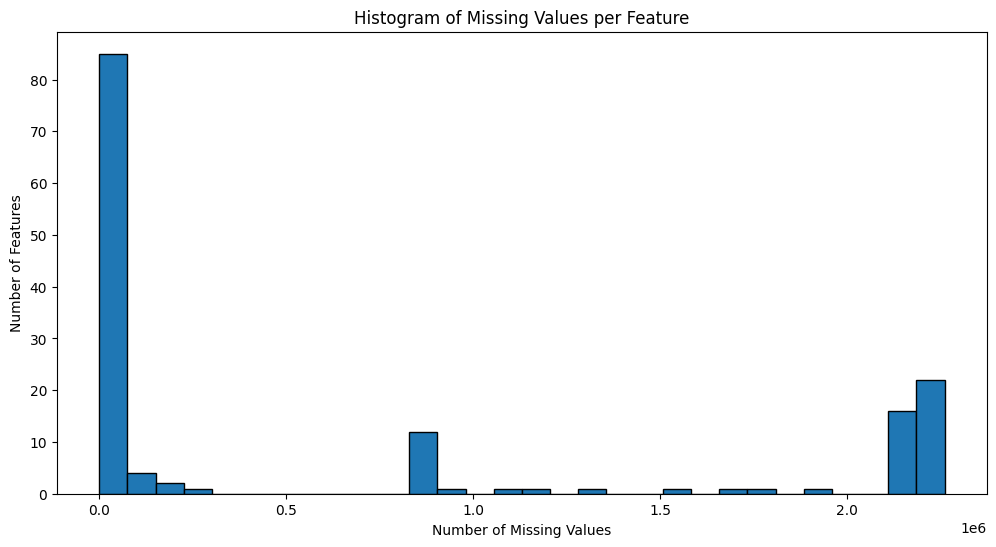

---

### Data Types

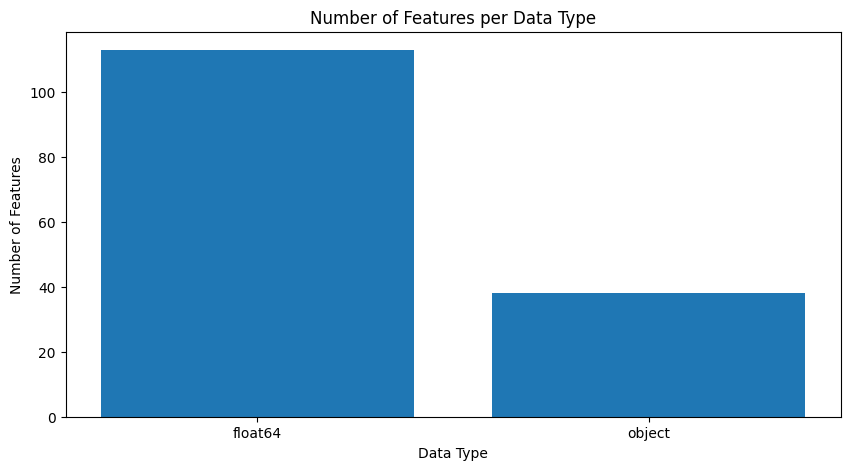

---

### Shape

(2260701, 151)

---

In [3]:
def Explore(df, show_missing=False ,show_dtypes=False, show_unique_count=False, show_shape=False):
    if show_missing:
        # Display count of all missing values in each column
        display(Markdown("### Missing Values"))
        
        # Sum of missing values in each column and convertion to a dataframe.
        missing_values = df.isnull().sum()
        missing_values = missing_values[missing_values > 0]

        # histogram
        plt.figure(figsize=(12, 6))
        plt.hist(missing_values.values, bins=30, edgecolor='black')  # adjust bins as needed
        plt.xlabel("Number of Missing Values")
        plt.ylabel("Number of Features")
        plt.title("Histogram of Missing Values per Feature")
        plt.show()
        display(Markdown("---"))    

    if show_dtypes:
        # Display data types
        display(Markdown("### Data Types"))

        # Identify data types
        data_types = df.dtypes
        
        # Count number of features per dtype
        dtype_counts = data_types.value_counts()

        # Barchart
        plt.figure(figsize=(10, 5))
        plt.bar(dtype_counts.index.astype(str), dtype_counts.values)
        plt.xlabel("Data Type")
        plt.ylabel("Number of Features")
        plt.title("Number of Features per Data Type")
        plt.show()        
        display(Markdown("---"))    

    if show_unique_count:
        # Display section header
        display(Markdown("### Number of Unique Values (Object Columns Only)"))
        
        # 1. Select only object columns
        object_cols = df.select_dtypes(include='object').columns
        
        # 2. Compute unique value counts for each object column
        unique_counts = df[object_cols].nunique()

        # 3. Plot a bar chart
        plt.figure(figsize=(12, 6))
        plt.bar(unique_counts.index, unique_counts.values)
        plt.xticks(rotation=45, ha='right')
        plt.xlabel("Object Columns")
        plt.ylabel("Number of Unique Values")
        plt.title("Unique Value Counts per Object Column")
        plt.tight_layout()
        plt.show()        
        display(Markdown("---"))        

    if show_shape:
        display(Markdown("### Shape"))
        display(df.shape)
        display(Markdown("---"))

Explore(credit_df, show_missing=True ,show_dtypes=True, show_unique_count=False, show_shape=True)

### **Ideal Columns For Credit Risk Modelling in Real Time**
#### **Credit Risk Fundamentals**
- fico_range_low
- fico_range_high
- dti
- revol_util
- annual_inc
#### **Delinquency History** 
- delinq_2yrs
- pub_rec_bankruptcies
- inq_last_6mths
#### Loan Characteristics 
- loan_amnt
- int_rate
- term
#### Credit Profile 
- total_acc
- open_acc
- credit_age_month (engineered from earliest_cr_line)
#### Categorical 
- home_ownership
- purpose
- emp_length
- addr_state
- verification_status
#### Label
- loan_status


### **Insights From Analyzing Credit Data and How Credit Operates**
- Most of the other columns are generated behind the scenes by sending API calls to Credit Bureaus, which are companies that collect finanancial data on individuals and businesses in terms of loans, credit cards, payment hinstory, defaults, bankruptcies etc. e.g. TransUnion, Experian and Equifax.
- To create a real time system using streamlit I'll only be using relevant features that are applicable in real time such the detailed above.

### Missing Values

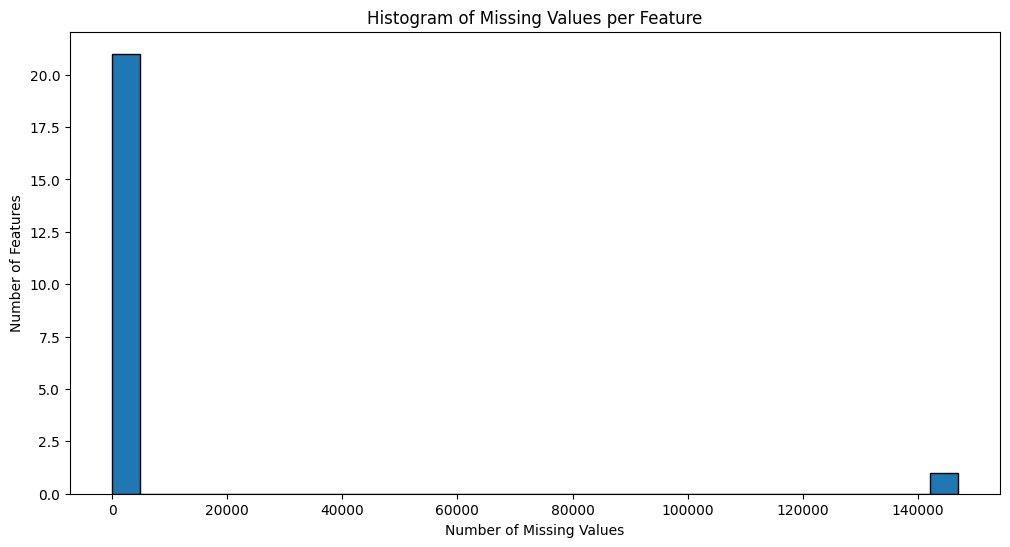

---

### Data Types

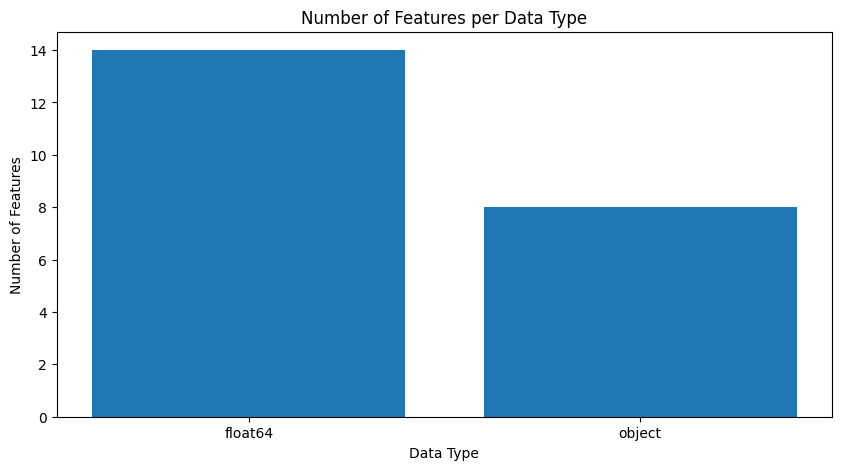

---

### Number of Unique Values (Object Columns Only)

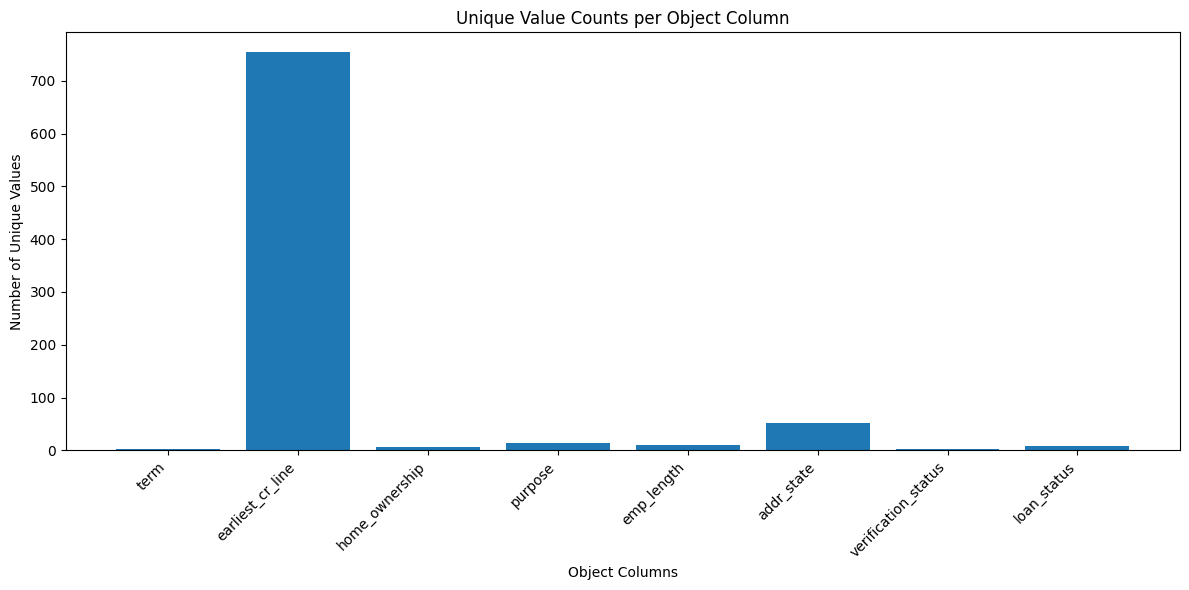

---

### Shape

(2260701, 22)

---

In [4]:
# Filter to only have relevant columns for further modelling
cols = ['fico_range_low', 'fico_range_high', 'dti', 'revol_bal', 'revol_util', 'annual_inc', 'delinq_2yrs', 'pub_rec', 
        'pub_rec_bankruptcies', 'inq_last_6mths', 'loan_amnt', 'term', 'total_acc', 'open_acc', 'earliest_cr_line', 
        'home_ownership', 'purpose', 'emp_length', 'addr_state', 'verification_status', 'collections_12_mths_ex_med', 'loan_status']

relevant_credit_df = credit_df[cols]
Explore(relevant_credit_df, show_missing=True ,show_dtypes=True, show_unique_count=True, show_shape=True)

# Feature Engineering
---
### Row-Level Transformations Only

In [5]:
# Make a deep copy of relevant_credit_df
relevant_credit_df = relevant_credit_df.copy()

# Convert earliest_cr_line to datetime
relevant_credit_df['earliest_cr_line'] = pd.to_datetime(
    relevant_credit_df['earliest_cr_line'])

# Get today's timestamp and calculate credit history in years
today = pd.Timestamp.today()
relevant_credit_df['credit_history_years'] = (
    (today - relevant_credit_df['earliest_cr_line']).dt.days / 365
)

# Income to loan ratio
relevant_credit_df['income_to_loan_ratio'] = relevant_credit_df['annual_inc'] / relevant_credit_df['loan_amnt']

# Fico score
relevant_credit_df['fico_score'] = (relevant_credit_df['fico_range_low'] + relevant_credit_df['fico_range_high']) /2

# Account utilization
relevant_credit_df['account_utilization'] = relevant_credit_df['open_acc'] / relevant_credit_df['total_acc']

# Avg credit per account
relevant_credit_df['avg_credit_per_account'] = np.where(
    relevant_credit_df['open_acc'] > 0,
    relevant_credit_df['revol_bal'] / relevant_credit_df['open_acc'],
    0
)

# Deliquency rate
relevant_credit_df['deliquency_rate'] = np.where(
    relevant_credit_df['total_acc'] > 0,
    relevant_credit_df['delinq_2yrs'] / relevant_credit_df['total_acc'],
    0
)

# Drop irrelavent features after engineering
relevant_credit_df.drop(columns='earliest_cr_line')

# Display engineered features
# relevant_credit_df[['credit_history_years', 'income_to_loan_ratio', 'fico_score', 'account_utilization', 'revol_bal','total_acc','open_acc', 'delinq_2yrs', 'deliquency_rate','avg_credit_per_account']].query("deliquency_rate > 0.4")

/tmp/ipykernel_88/1148206564.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  relevant_credit_df['earliest_cr_line'] = pd.to_datetime(
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_v

,fico_range_low,fico_range_high,dti,revol_bal,revol_util,annual_inc,delinq_2yrs,pub_rec,pub_rec_bankruptcies,inq_last_6mths,...,addr_state,verification_status,collections_12_mths_ex_med,loan_status,credit_history_years,income_to_loan_ratio,fico_score,account_utilization,avg_credit_per_account,deliquency_rate
0,675.0,679.0,5.91,2765.0,29.7,55000.0,0.0,0.0,0.0,1.0,...,PA,Not Verified,0.0,Fully Paid,22.375342,15.277778,677.0,0.538462,395.000000,0.000000
1,715.0,719.0,16.06,21470.0,19.2,65000.0,1.0,0.0,0.0,4.0,...,SD,Not Verified,0.0,Fully Paid,26.043836,2.631579,717.0,0.578947,975.909091,0.026316
2,695.0,699.0,10.78,7869.0,56.2,63000.0,0.0,0.0,0.0,0.0,...,IL,Not Verified,0.0,Fully Paid,25.375342,3.150000,697.0,0.333333,1311.500000,0.000000
3,785.0,789.0,17.06,7802.0,11.6,110000.0,0.0,0.0,0.0,0.0,...,NJ,Source Verified,0.0,Current,17.284932,3.142857,787.0,0.764706,600.153846,0.000000
4,695.0,699.0,25.37,21929.0,64.5,104433.0,1.0,0.0,0.0,3.0,...,PA,Source Verified,0.0,Fully Paid,27.545205,10.041635,697.0,0.342857,1827.416667,0.028571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260696,705.0,709.0,12.75,8633.0,64.9,227000.0,7.0,0.0,0.0,1.0,...,CA,Verified,0.0,Current,30.876712,5.675000,707.0,0.135135,1726.600000,0.189189
2260697,660.0,664.0,18.30,17641.0,68.1,110000.0,0.0,1.0,1.0,0.0,...,FL,Not Verified,0.0,Charged Off,26.463014,4.583333,662.0,0.322581,1764.100000,0.000000
2260698,660.0,664.0,23.36,7662.0,54.0,95000.0,0.0,0.0,0.0,1.0,...,TX,Verified,0.0,Current,29.545205,6.785714,662.0,0.363636,957.750000,0.000000
2260699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000


### Target Encoding

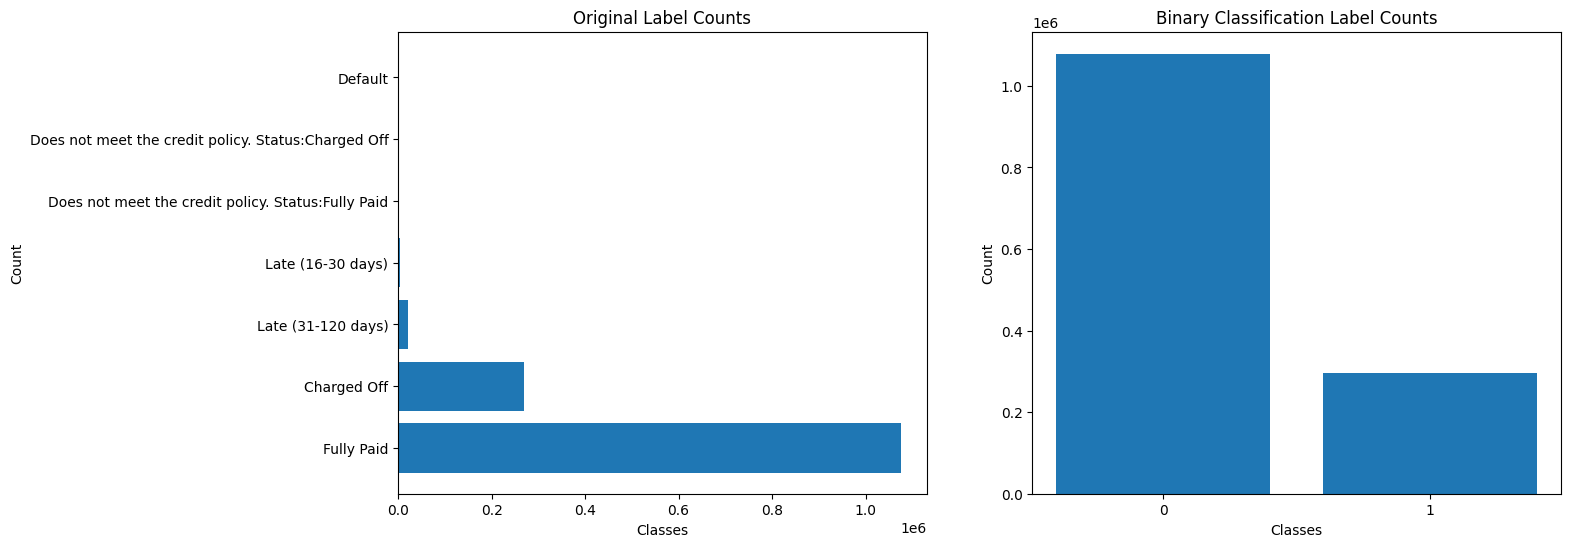

In [6]:
# Example: your loan status series
loan_status = pd.Series([
    'Fully Paid', 'Current', 'Charged Off', 'Late (31-120 days)',
    'In Grace Period', 'Late (16-30 days)',
    'Does not meet the credit policy. Status:Fully Paid',
    'Does not meet the credit policy. Status:Charged Off',
    'Default'
])

# Mapping to binary target
default_mapping = {
    'Charged Off': 1,
    'Default': 1,
    'Late (31-120 days)': 1,
    'Late (16-30 days)': 1,
    'Does not meet the credit policy. Status:Charged Off': 1,
    'Fully Paid': 0,
    'Does not meet the credit policy. Status:Fully Paid': 0
    # 'Current': 0,              # include cautiously
    # 'In Grace Period': 0       # treat cautiously
}

# Defein the statuses to keep
statuses_to_keep = list(default_mapping.keys())

# Filter dataframe
relevant_credit_df = relevant_credit_df[relevant_credit_df['loan_status'].isin(statuses_to_keep)]

# Map the remaining statuses to 0 = paid and 1 = default
relevant_credit_df.loc[:, 'loan_status_binary'] = relevant_credit_df['loan_status'].map(default_mapping)


# plot a count based bar plot to identify class imbalance
loan_status_count         = relevant_credit_df['loan_status'].value_counts()
loan_status_binanry_count = relevant_credit_df['loan_status_binary'].value_counts()

# Plot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].barh(loan_status_count.index.astype(str), loan_status_count.values)
ax[0].set_xlabel('Classes')
ax[0].set_ylabel('Count')
ax[0].set_title('Original Label Counts')

ax[1].bar(loan_status_binanry_count.index.astype(str), loan_status_binanry_count.values)
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Count')
ax[1].set_title('Binary Classification Label Counts')

plt.show()


# Removing Data Quality Issues (Before Split)
---

In [7]:
# Assess how many rows are missing values across the selected 20 columns
# Count missing values accross columns, filter out those with no missing values and sort in descending order
null_count_per_row = relevant_credit_df.isnull().sum(axis=1)
null_count_per_row = null_count_per_row[null_count_per_row > 0]
null_count_per_row = null_count_per_row.sort_values(ascending=False)
display(null_count_per_row.value_counts())

1     82500
2       546
11       25
13        4
3         4
Name: count, dtype: int64

### Missing Values

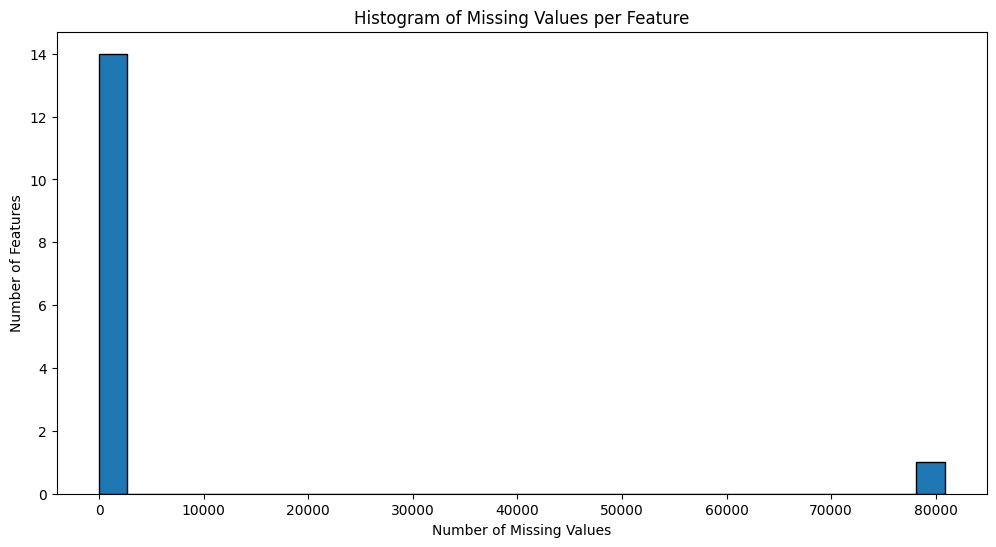

---

### Number of Unique Values (Object Columns Only)

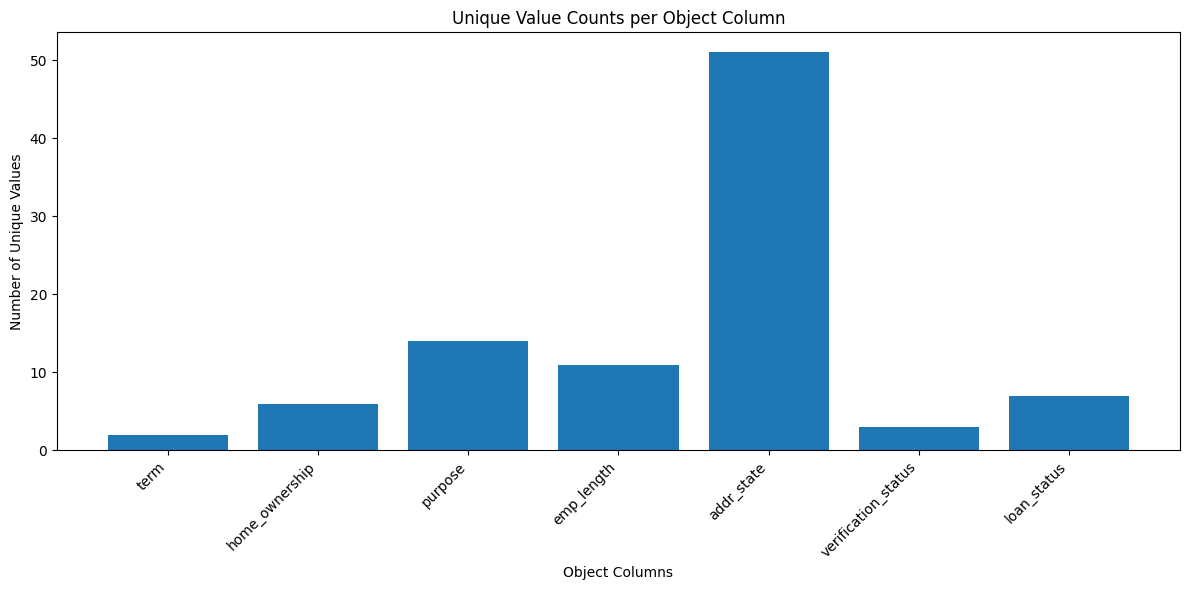

---

In [8]:
# Drop all rows with 20 missing values, essentially corrupt rows with no useable data
relevant_credit_df = relevant_credit_df.dropna(how='all')

# Re-examine data
Explore(relevant_credit_df, show_missing=True ,show_dtypes=False, show_unique_count=True, show_shape=False)

# Train-Test Split 
---

In [9]:
from sklearn.model_selection import train_test_split, KFold

In [10]:
X = relevant_credit_df.drop(columns=['loan_status', 'loan_status_binary'])
y = relevant_credit_df['loan_status_binary']

print(X.shape)
print(y.shape)

(1373915, 27)
(1373915,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41, stratify=y)

print(f"X train shape: {X_train.shape}")
print(f"y train shape: {y_train.shape}")
print(f"X test shape: {X_test.shape}")
print(f"y test shape: {y_test.shape}")

X train shape: (1099132, 27)
y train shape: (1099132,)
X test shape: (274783, 27)
y test shape: (274783,)


# Imputation and Encoding (After Data Splitting)
---

In [12]:
# !pip install imblearn

In [13]:
import time
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE

In [14]:
# Separate numeric and categorical values for imputation and scalling
numerical_cols = X_train.select_dtypes(include='number').columns
categorical_cols = X_train.select_dtypes(include='object').columns
print(f"Numeric Columns: {numerical_cols}")
print(f"Categorical Columns: {categorical_cols}")

Numeric Columns: Index(['fico_range_low', 'fico_range_high', 'dti', 'revol_bal', 'revol_util',
       'annual_inc', 'delinq_2yrs', 'pub_rec', 'pub_rec_bankruptcies',
       'inq_last_6mths', 'loan_amnt', 'total_acc', 'open_acc',
       'collections_12_mths_ex_med', 'credit_history_years',
       'income_to_loan_ratio', 'fico_score', 'account_utilization',
       'avg_credit_per_account', 'deliquency_rate'],
      dtype='object')
Categorical Columns: Index(['term', 'home_ownership', 'purpose', 'emp_length', 'addr_state',
       'verification_status'],
      dtype='object')


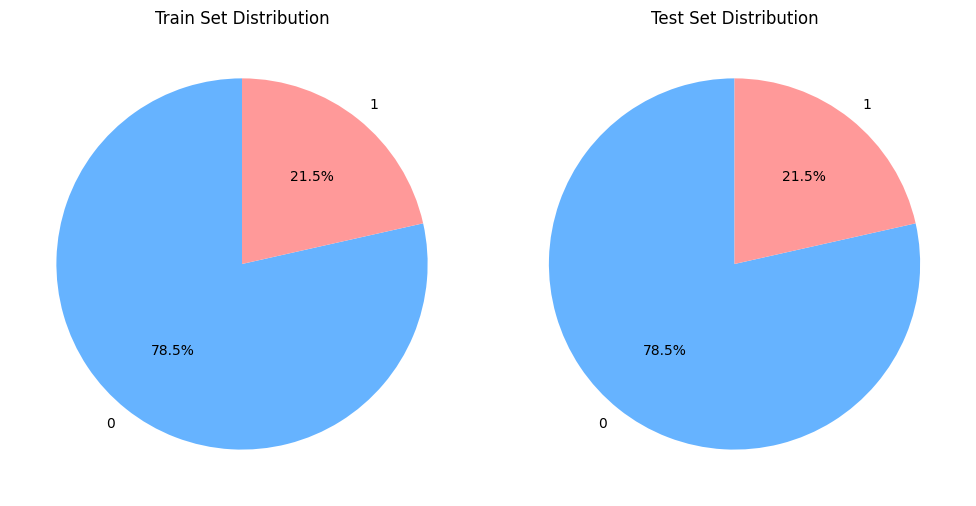

y train:  loan_status_binary
0    862991
1    236141
Name: count, dtype: int64

y test:  loan_status_binary
0    215748
1     59035
Name: count, dtype: int64


In [15]:
# Create imputers
numeric_imputer = SimpleImputer(strategy="median")
categorical_imputer = SimpleImputer(strategy="most_frequent")

# Numerical pipeline
numeric_pipeline = Pipeline([
    ('imputer', numeric_imputer),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_pipeline = Pipeline([
    ('imputer', categorical_imputer),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine into 1 preprocessing step
preproces = ColumnTransformer([
    ("num", numeric_pipeline, numerical_cols),
    ("cat", categorical_pipeline, categorical_cols)
])

# Fit only on training data
preproces.fit(X_train)

# transform on all data
X_train_preprocessed = preproces.transform(X_train)
X_test_preprocessed = preproces.transform(X_test)

# After preproces.fit() and transform, extract feature names
feature_names = preproces.get_feature_names_out()

X_train_df = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_preprocessed, columns=feature_names)

# Class distributions
y_train_counts = y_train.value_counts()
y_test_counts  = y_test.value_counts()

# Define labels
labels = y_train_counts.index.astype(str)  # assuming classes are 0,1 etc.

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Pie chart for training set
axes[0].pie(y_train_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
axes[0].set_title("Train Set Distribution")

# Pie chart for test set
axes[1].pie(y_test_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
axes[1].set_title("Test Set Distribution")

plt.tight_layout()
plt.show()

print("y train: ", y_train.value_counts())
print("\ny test: ", y_test.value_counts())

Correcting class imbalance using SMOTE
SMOTE took: 5.43 minutes

AFTER SMOTE:
y train resampled:  loan_status_binary
1    862991
0    862991
Name: count, dtype: int64


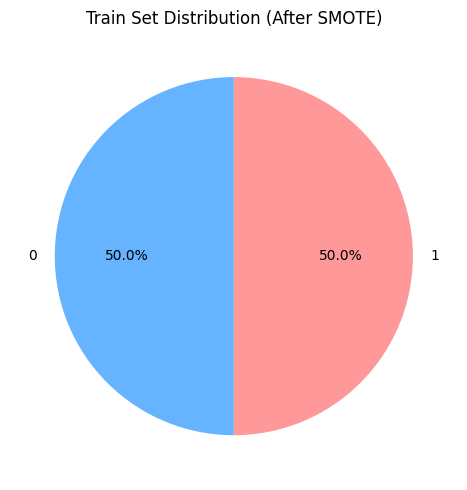

In [16]:
# ==================== SMOTE ====================
# Pure SMOTE
smote = SMOTE(random_state=42)
print("Correcting class imbalance using SMOTE")
smote_start_time = time.time()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)
smote_end_time = time.time() - smote_start_time
print(f"SMOTE took: {(smote_end_time/60):.2f} minutes")

# Convert back to DataFrame for consistency
X_train_df_resampled = pd.DataFrame(X_train_resampled, columns=feature_names)
y_train_resampled = pd.Series(y_train_resampled, name=y_train.name)

print("\nAFTER SMOTE:")
print("y train resampled: ", y_train_resampled.value_counts())

# Visualize AFTER SMOTE
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
y_train_resampled_counts = y_train_resampled.value_counts()
ax.pie(y_train_resampled_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
ax.set_title("Train Set Distribution (After SMOTE)")
plt.tight_layout()
plt.show()


# Explore Models
---

In [17]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score

import shap

In [40]:
def plot_shap_importance(model, X_train_preprocessed, model_name, feature_names=None):
    print(f"\nGenerating SHAP explanations for {model_name}...")
    
    # -------------------------------
    # 1. Convert to numpy array if DataFrame
    # -------------------------------
    if hasattr(X_train_preprocessed, 'values'):
        X_array = X_train_preprocessed.values
        if feature_names is None:
            feature_names = X_train_preprocessed.columns
    else:
        X_array = X_train_preprocessed
    
    # -------------------------------
    # 2. Clean feature names
    # -------------------------------
    if feature_names is not None:
        clean_feature_names = [str(f).replace('[','_').replace(']','').replace('<','_').replace('>','_') 
                               for f in feature_names]
    else:
        clean_feature_names = None
    
    # -------------------------------
    # 3. Sample data to speed up plotting
    # -------------------------------
    max_samples = 10000
    n_rows = X_array.shape[0]
    if n_rows > max_samples:
        idx = np.random.choice(n_rows, max_samples, replace=False)
        X_sample = X_array[idx]
    else:
        X_sample = X_array
    
    # -------------------------------
    # 4. Create SHAP explainer
    # -------------------------------
    if "logistic regression" in model_name.lower():
        explainer = shap.LinearExplainer(model, X_sample)
    else:
        explainer = shap.TreeExplainer(model)
    
    # -------------------------------
    # 5. Compute SHAP values
    # -------------------------------
    shap_values = explainer.shap_values(X_sample)
    
    # For binary classification, handle output format
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Use positive class
    
    # -------------------------------
    # 6. Plot SHAP summary plots - SEPARATE FIGURES
    # -------------------------------
    
    # Bar plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, 
                      X_sample, 
                      feature_names=clean_feature_names, 
                      plot_type="bar", 
                      show=False)
    plt.title(f"SHAP Feature Importance - {model_name}")
    plt.tight_layout()
    plt.show()
    
    # Dot plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, 
                      X_sample, 
                      feature_names=clean_feature_names, 
                      show=False)
    plt.title(f"SHAP Summary Plot - {model_name}")
    plt.tight_layout()
    plt.show()
    
    return shap_values

Training Logistic Regression
Logistic Regression took 0.36 minutes or 21.48 seconds

Best threshold: 0.506, Best F1-score 0.429
Accuracy: 0.65 

Classification Report.
              precision    recall  f1-score   support

           0       0.86      0.65      0.74    215748
           1       0.33      0.62      0.43     59035

    accuracy                           0.65    274783
   macro avg       0.60      0.64      0.59    274783
weighted avg       0.75      0.65      0.68    274783
 



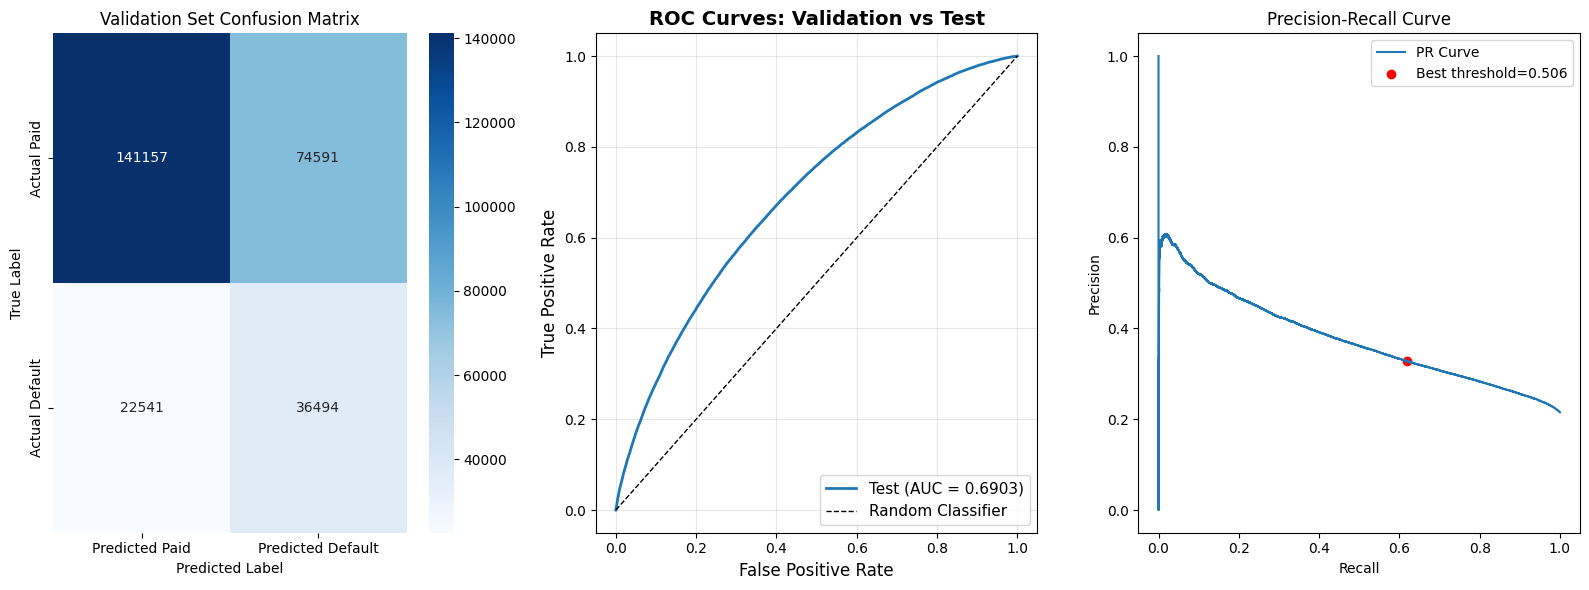


Generating SHAP explanations for Logistic Regression...


The figure layout has changed to tight


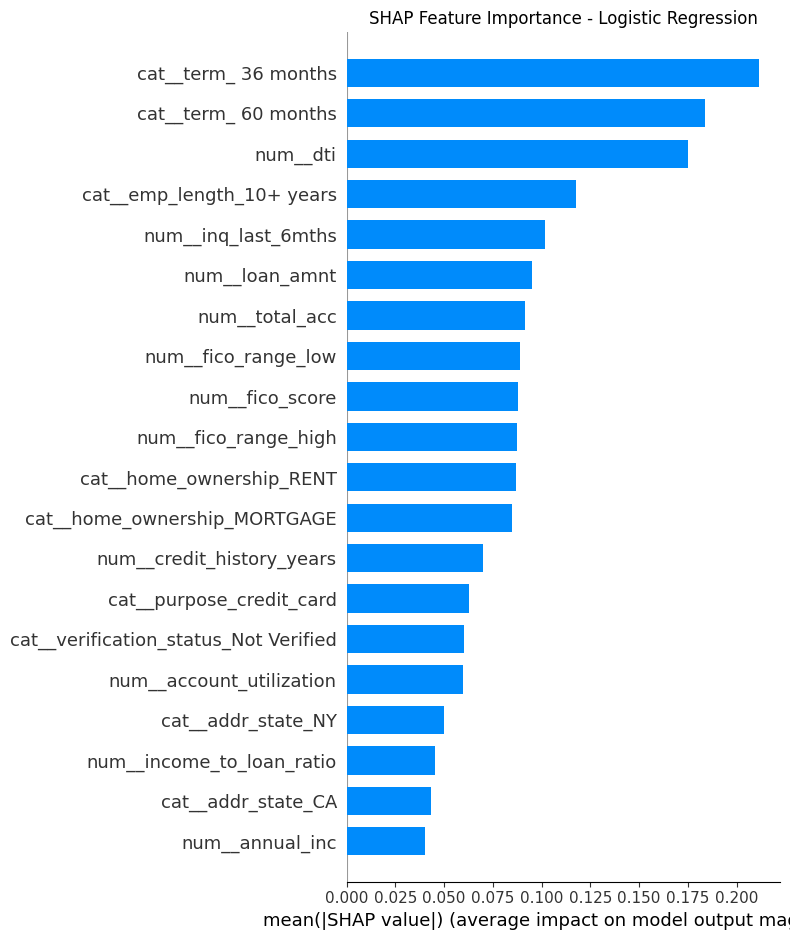

The figure layout has changed to tight


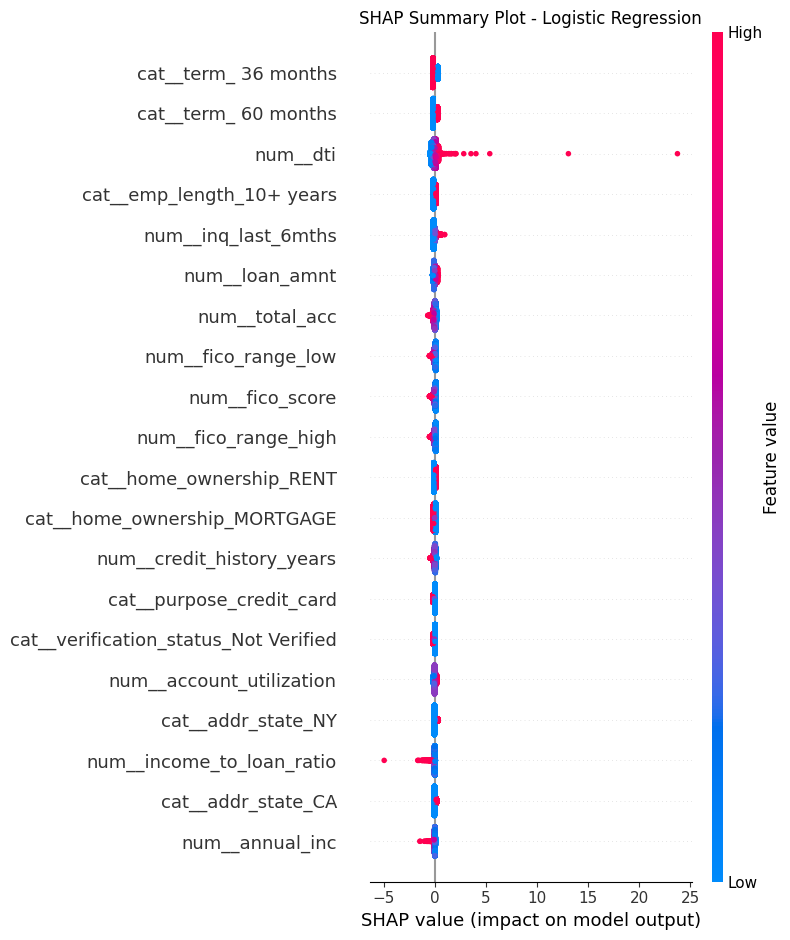

Shap analysis for Logistic Regression took 0.04 minutes or 2.45 seconds
Training XGB Classifier
XGB Classifier took 1.26 minutes or 75.54 seconds

Best threshold: 0.305, Best F1-score 0.430
Accuracy: 0.63 

Classification Report.
              precision    recall  f1-score   support

           0       0.87      0.63      0.73    215748
           1       0.32      0.65      0.43     59035

    accuracy                           0.63    274783
   macro avg       0.59      0.64      0.58    274783
weighted avg       0.75      0.63      0.66    274783
 



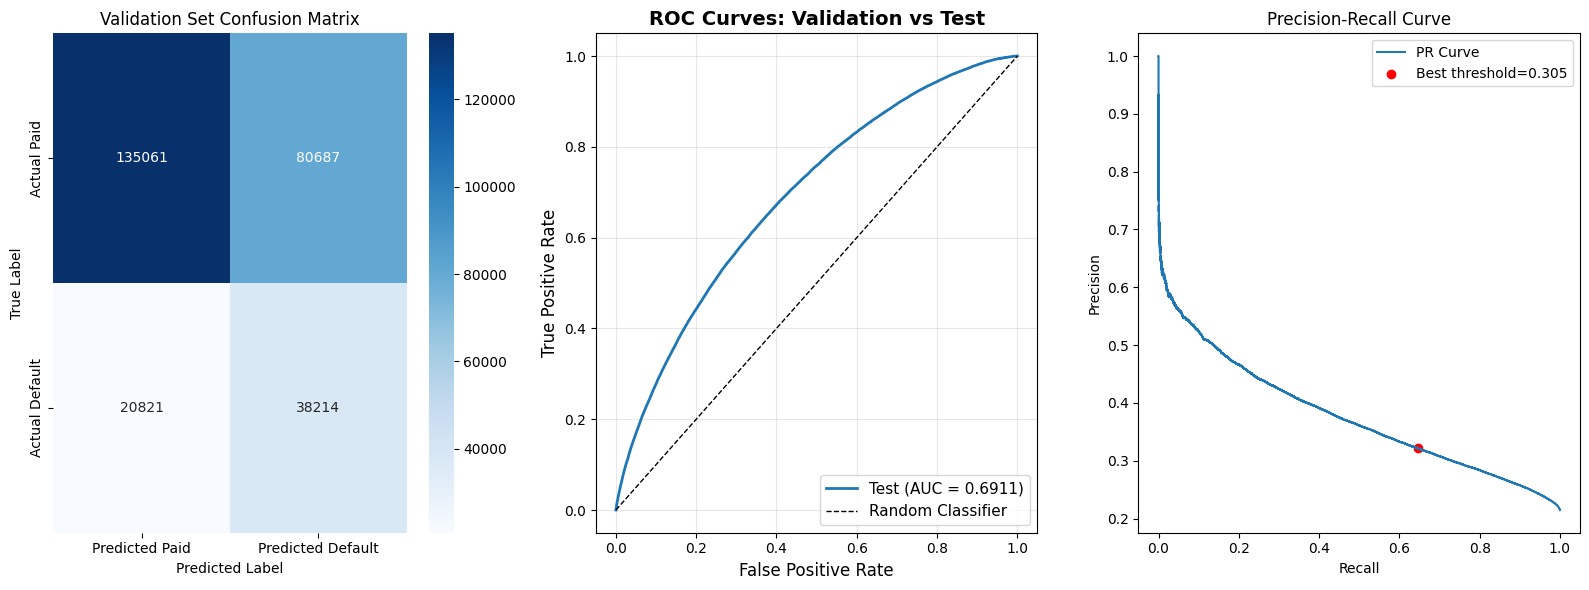


Generating SHAP explanations for XGB Classifier...


The figure layout has changed to tight


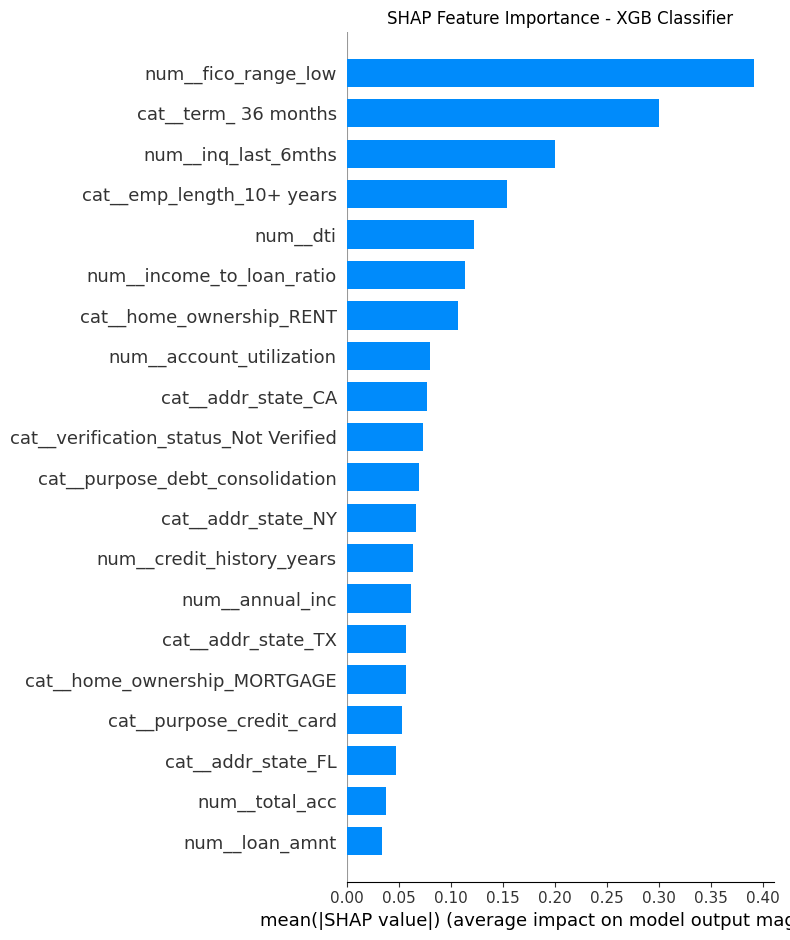

The figure layout has changed to tight


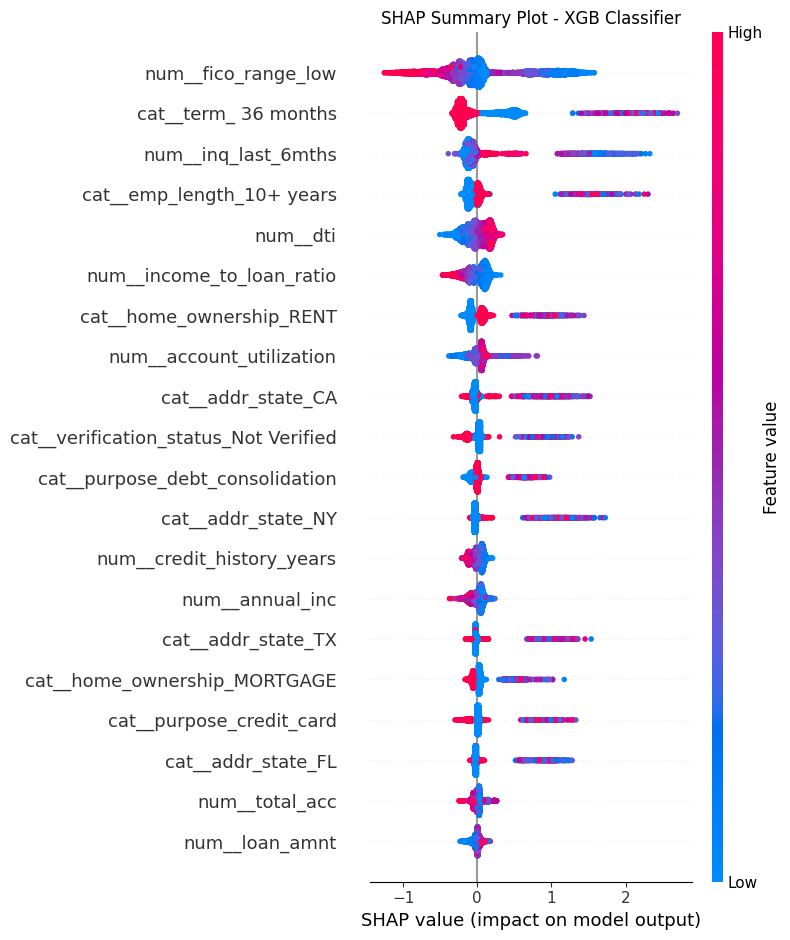

Shap analysis for XGB Classifier took 0.17 minutes or 10.03 seconds
Training LGBM Classifier
[LightGBM] [Info] Number of positive: 862991, number of negative: 862991
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.729567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23647
[LightGBM] [Info] Number of data points in the train set: 1725982, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LGBM Classifier took 0.43 minutes or 25.59 seconds



X does not have valid feature names, but LGBMClassifier was fitted with feature names
X does not have valid feature names, but LGBMClassifier was fitted with feature names


Best threshold: 0.245, Best F1-score 0.435
Accuracy: 0.64 

Classification Report.
              precision    recall  f1-score   support

           0       0.87      0.64      0.74    215748
           1       0.33      0.64      0.43     59035

    accuracy                           0.64    274783
   macro avg       0.60      0.64      0.59    274783
weighted avg       0.75      0.64      0.67    274783
 



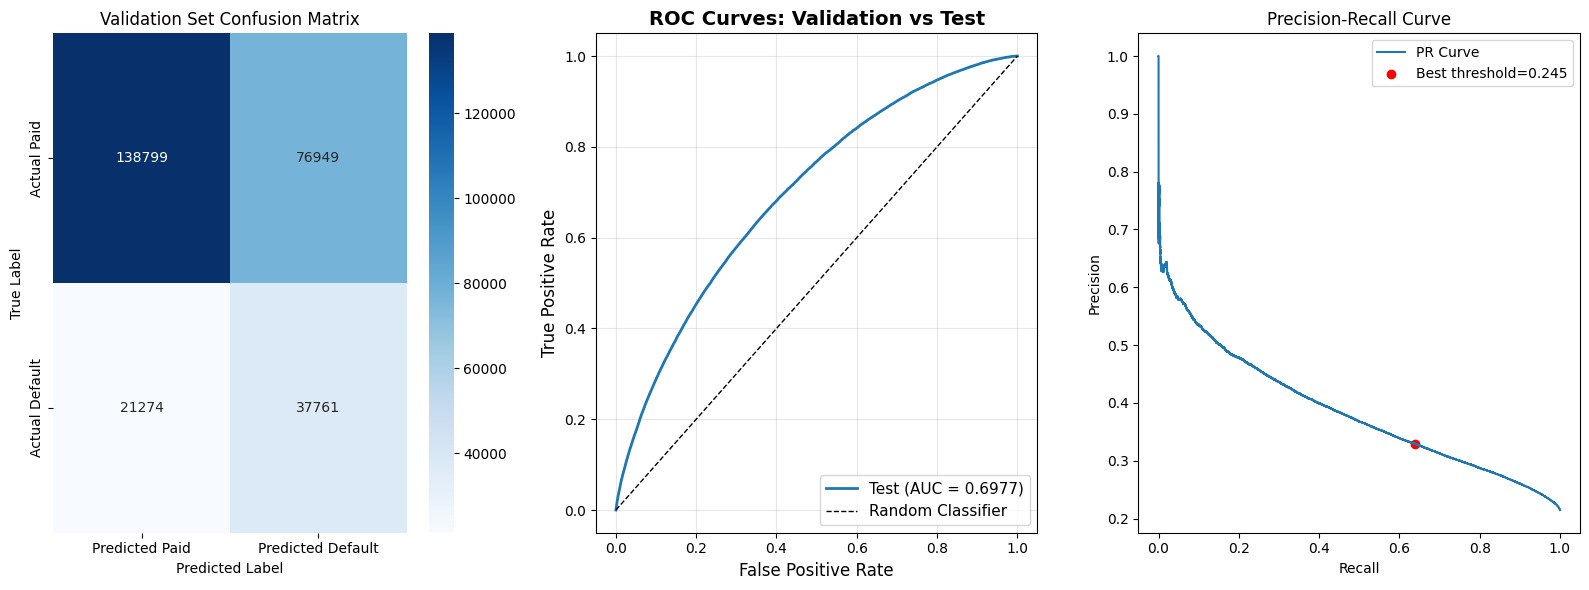


Generating SHAP explanations for LGBM Classifier...


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
The figure layout has changed to tight


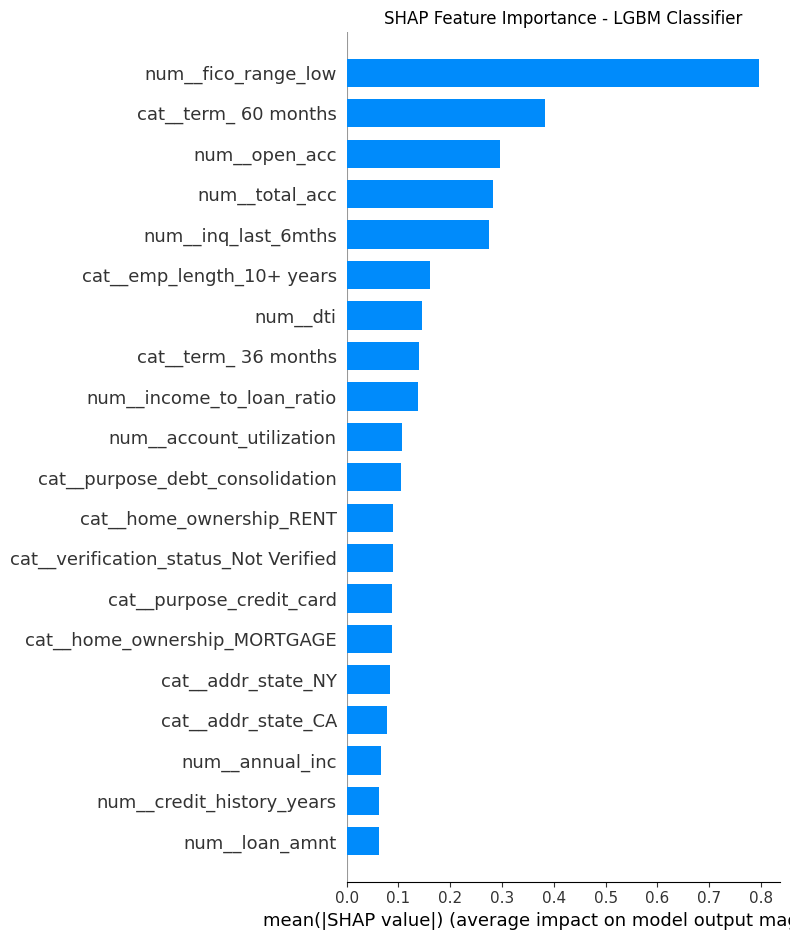

The figure layout has changed to tight


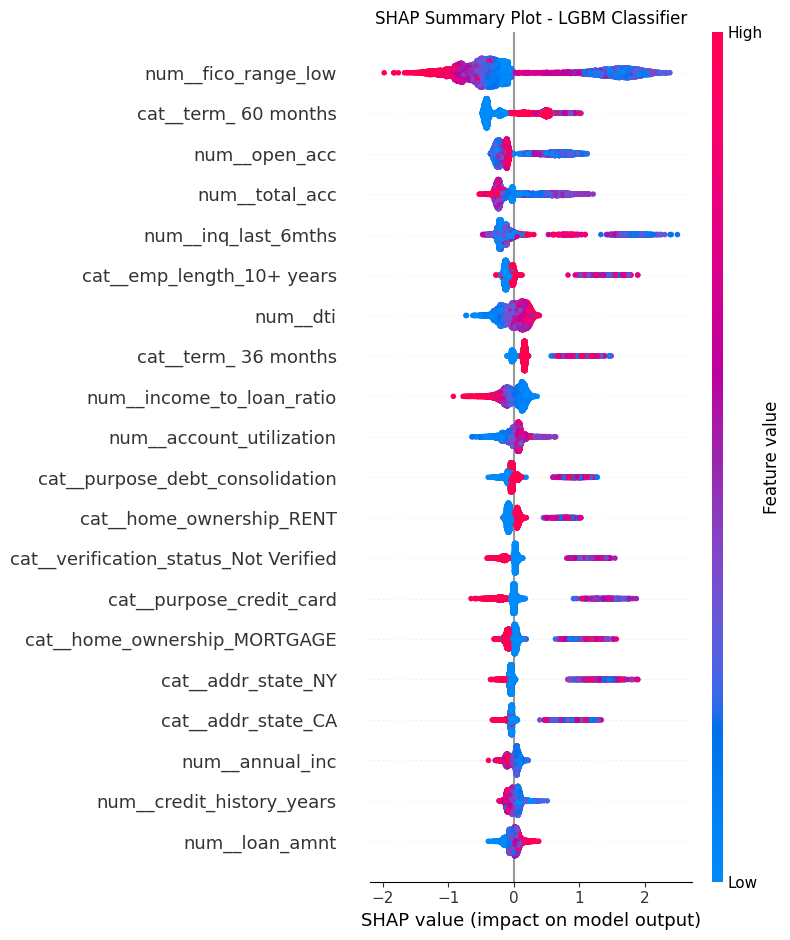

Shap analysis for LGBM Classifier took 0.11 minutes or 6.84 seconds
Training Cat Boost Classifier
Cat Boost Classifier took 1.83 minutes or 109.96 seconds

Best threshold: 0.258, Best F1-score 0.434
Accuracy: 0.65 

Classification Report.
              precision    recall  f1-score   support

           0       0.86      0.66      0.75    215748
           1       0.33      0.62      0.43     59035

    accuracy                           0.65    274783
   macro avg       0.60      0.64      0.59    274783
weighted avg       0.75      0.65      0.68    274783
 



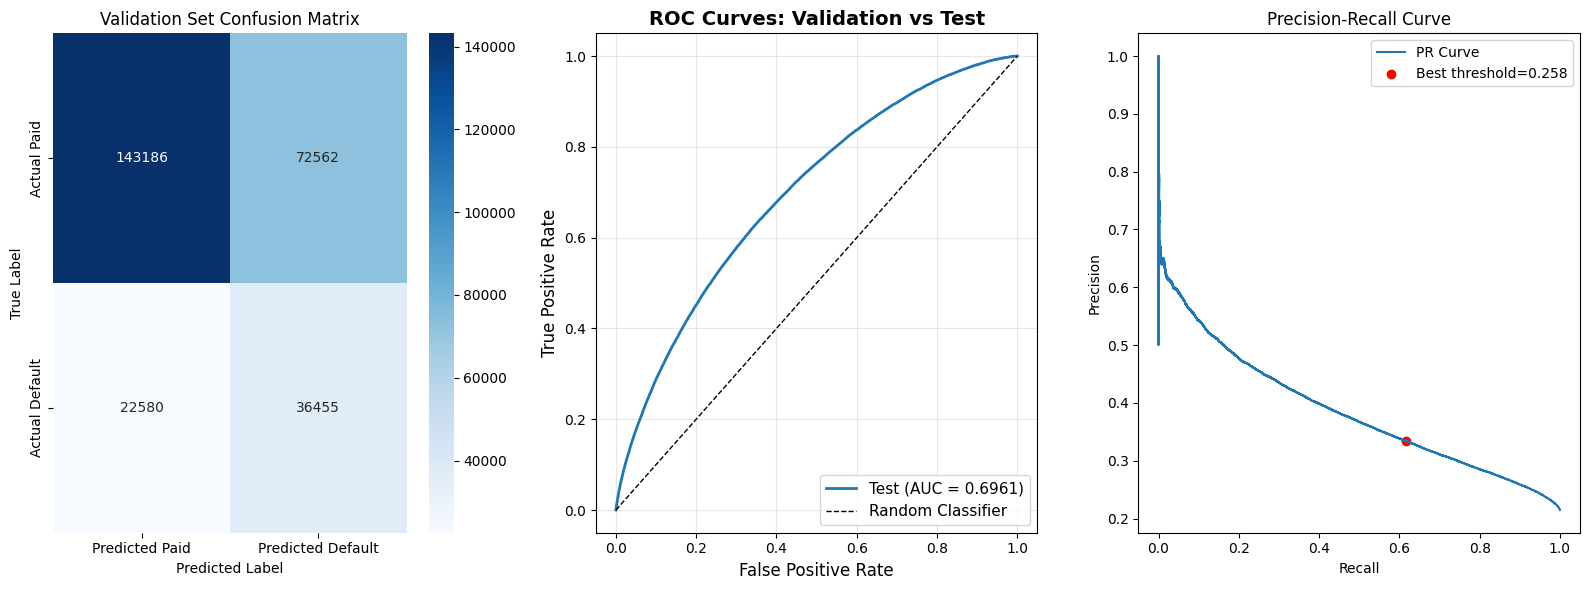


Generating SHAP explanations for Cat Boost Classifier...


The figure layout has changed to tight


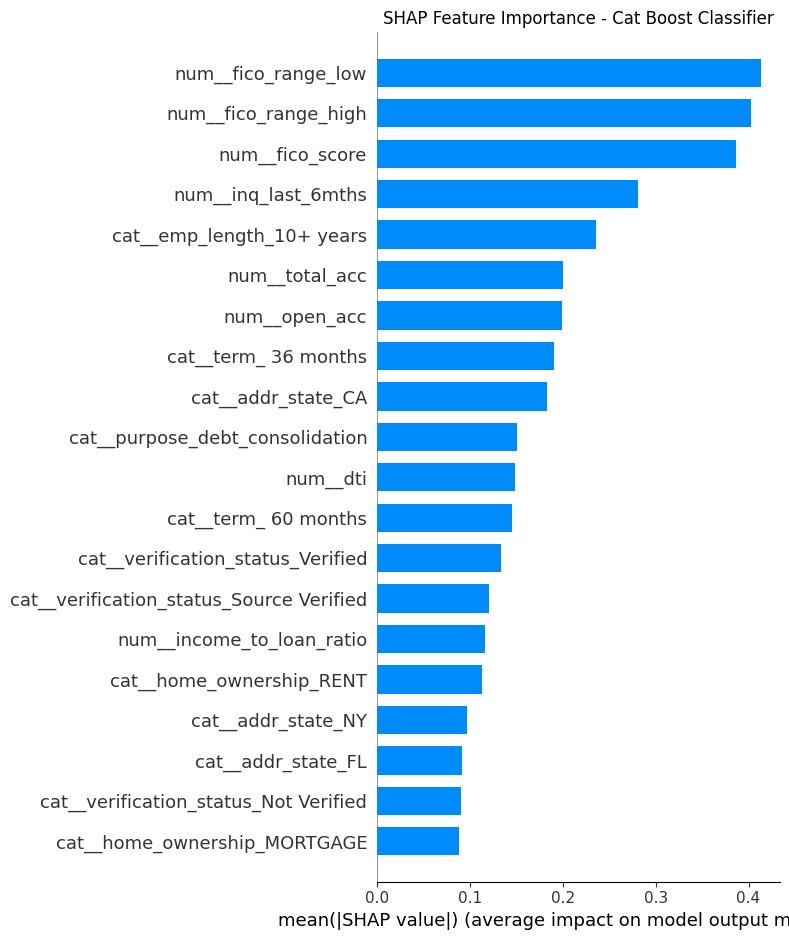

The figure layout has changed to tight


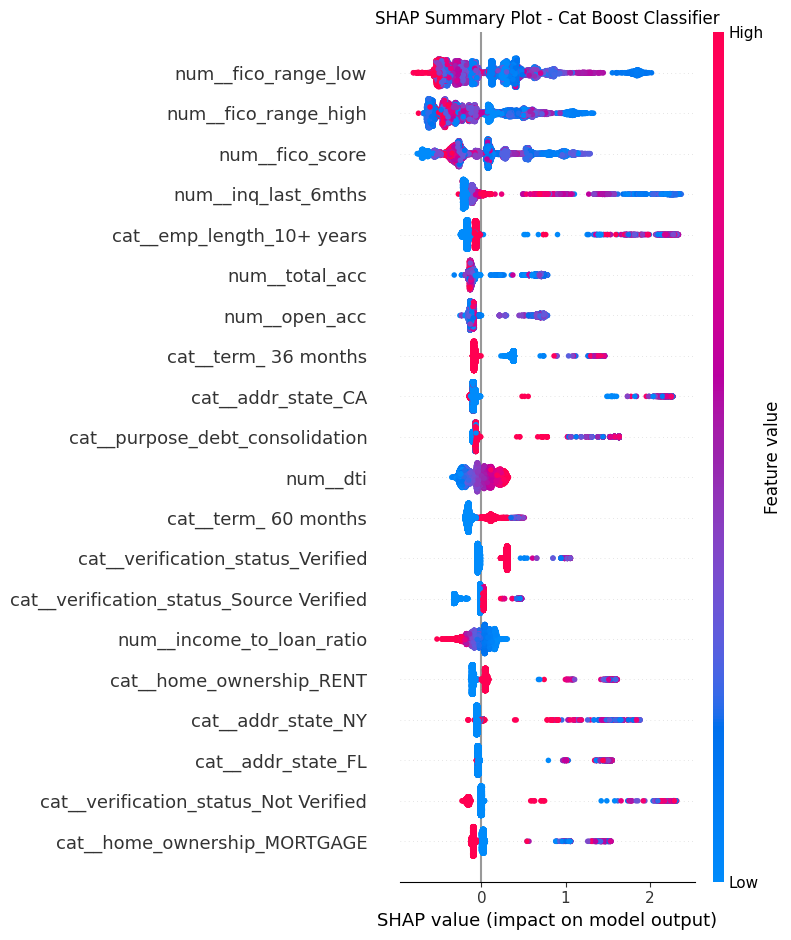

Shap analysis for Cat Boost Classifier took 0.06 minutes or 3.57 seconds
Training Random Forest Classifier
Random Forest Classifier took 3.78 minutes or 227.00 seconds

Best threshold: 0.451, Best F1-score 0.422
Accuracy: 0.62 

Classification Report.
              precision    recall  f1-score   support

           0       0.86      0.62      0.72    215748
           1       0.32      0.64      0.42     59035

    accuracy                           0.62    274783
   macro avg       0.59      0.63      0.57    274783
weighted avg       0.74      0.62      0.66    274783
 



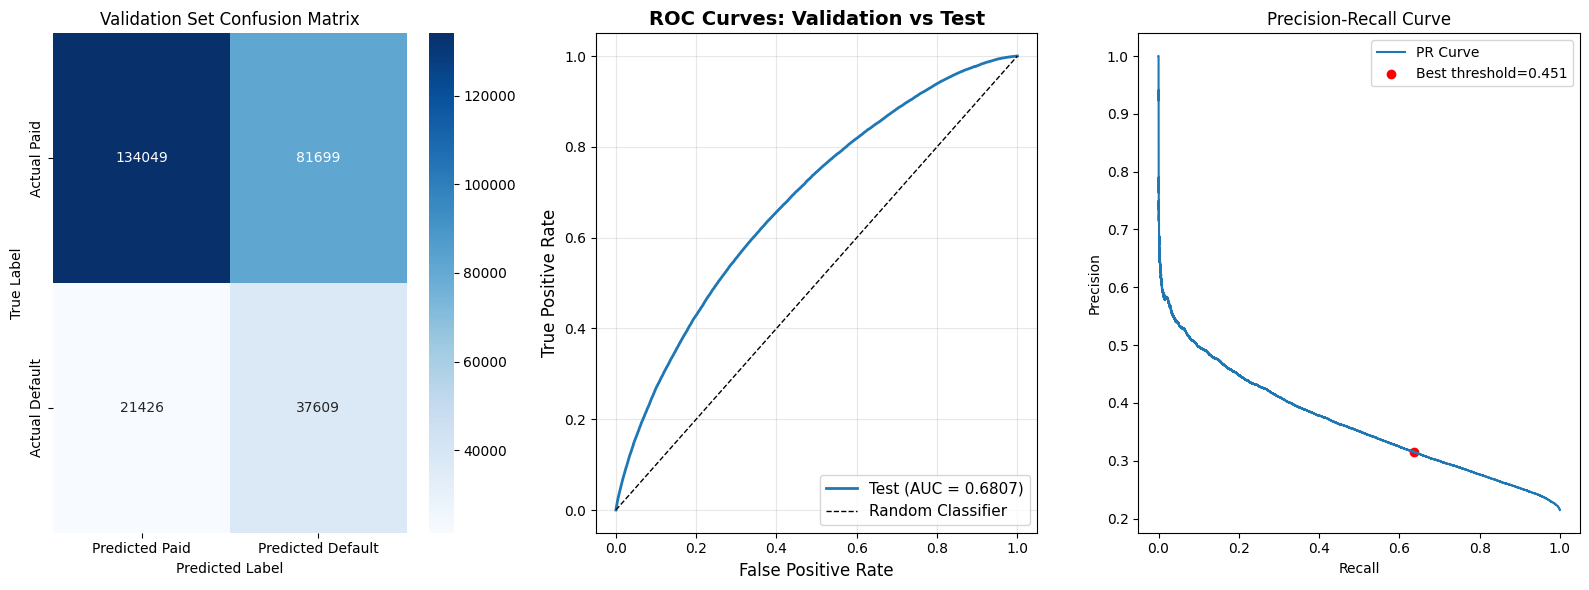


Generating SHAP explanations for Random Forest Classifier...


The figure layout has changed to tight


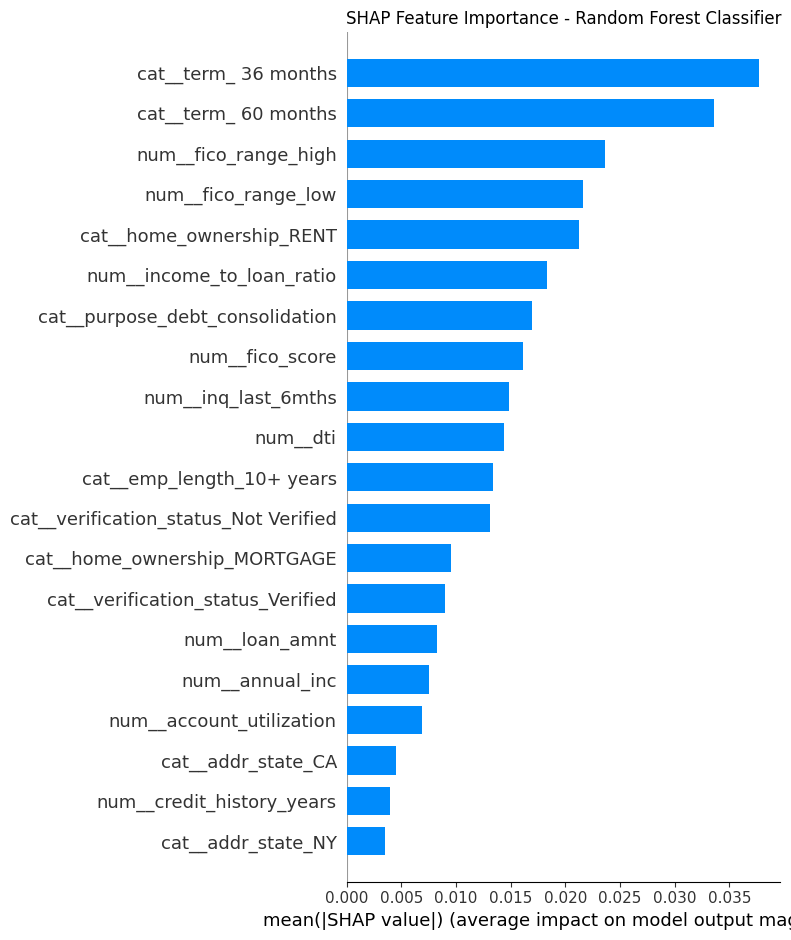

The figure layout has changed to tight


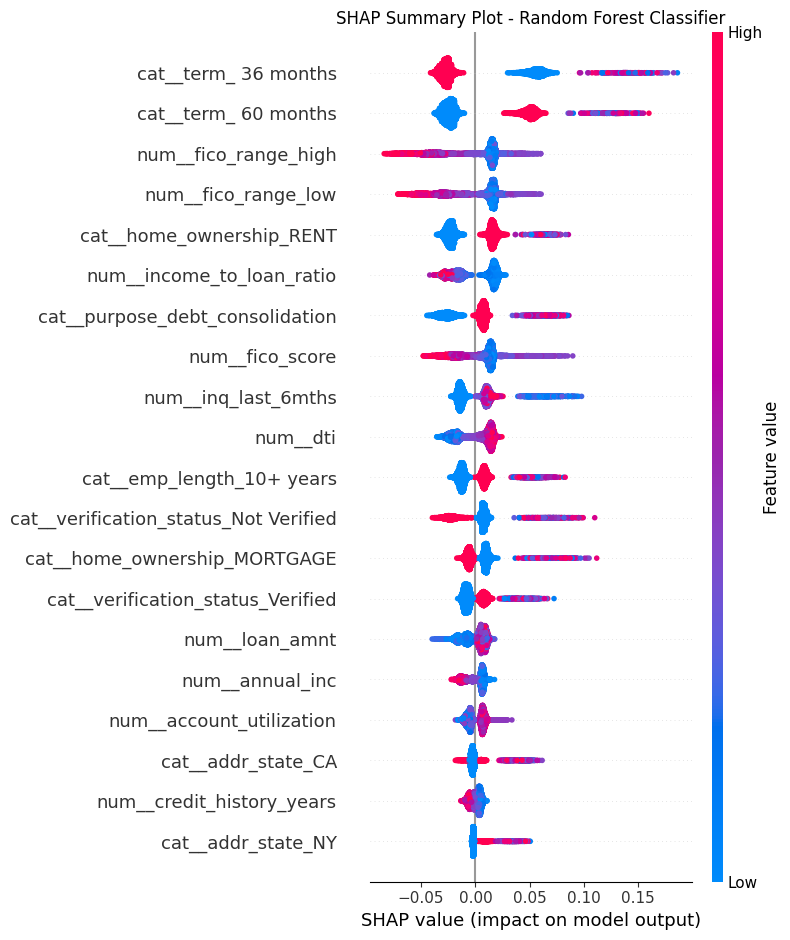

Shap analysis for Random Forest Classifier took 4.17 minutes or 250.27 seconds


In [47]:
models = {
    'Logistic Regression' : LogisticRegression(
                                max_iter=1000, 
                                random_state=42),
    'XGB Classifier' : xgb.XGBClassifier(
                        n_estimators=100,
                        learning_rate=0.1,
                        max_depth=6,
                        random_state=42,
                        use_label_encoder=False,
                        eval_metric='logloss'),
    'LGBM Classifier' : lgb.LGBMClassifier(
                        n_estimators=100,
                        learning_rate=0.1,
                        max_depth=-1,
                        random_state=42),
    'Cat Boost Classifier' : CatBoostClassifier(
                                iterations=100,
                                learning_rate=0.1,
                                depth=6,
                                random_seed=42,
                                verbose=0),   
    'Random Forest Classifier' : RandomForestClassifier(
                                    n_estimators=100,
                                    max_depth=10,
                                    random_state=42,
                                    n_jobs=-1
                                )
}

# Save trained models
trained_models = {}

for model_name, model in models.items():
    print("=" * 60)
    print(f"Training {model_name}")
    print("=" * 60)

    # Train models and timing each individually.
    model_training_start = time.time()
    model.fit(X_train_resampled, y_train_resampled)
    model_training_end = time.time() - model_training_start
    print(f"{model_name} took {(model_training_end/60):.2f} minutes or {model_training_end:.2f} seconds\n")

    # Store the trained model
    trained_models[model_name] = model
    
    # Predicting on val and test datasets
    y_pred = model.predict(X_test_preprocessed)
    y_pred_proba = model.predict_proba(X_test_preprocessed)[:, 1]

    # Compute precision, recall and thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

    # Computer F1 for each threshold
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    
    # Find best threshold with max f1
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    print(f"Best threshold: {best_threshold:.3f}, Best F1-score {best_f1:.3f}")

    # Apply threshold to predictions
    y_pred_opt = (y_pred_proba >= best_threshold).astype(int)

    # Accuracy
    acc = accuracy_score(y_test, y_pred_opt)
    print(f"Accuracy: {acc:.2f} \n")

    # Classification Report
    print("Classification Report.")
    print(f"{classification_report(y_test, y_pred_opt)} \n")

    # ROC-AUC score
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Confusion Matrix Heatmap
    cm_test = confusion_matrix(y_test, y_pred_opt) 

    # ================== Plots ================== 
    fig, ax = plt.subplots(1, 3, figsize=(16,6))
    
    # Validation Confusion Matrix
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax[0], 
                xticklabels=['Predicted Paid', 'Predicted Default'],
                yticklabels=['Actual Paid', 'Actual Default'])
    ax[0].set_title('Validation Set Confusion Matrix')
    ax[0].set_ylabel('True Label')
    ax[0].set_xlabel('Predicted Label')
    
    # Calculate ROC curves
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba)
    
    # Plot ROC curves
    ax[1].plot(fpr_test, tpr_test, label=f'Test (AUC = {test_roc_auc:.4f})', linewidth=2)
    ax[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
    
    ax[1].set_xlabel('False Positive Rate', fontsize=12)
    ax[1].set_ylabel('True Positive Rate', fontsize=12)
    ax[1].set_title('ROC Curves: Validation vs Test', fontsize=14, fontweight='bold')
    ax[1].legend(loc='lower right', fontsize=11)
    ax[1].grid(alpha=0.3)

    ax[2].plot(recall, precision, label='PR Curve')
    ax[2].scatter(recall[best_idx], precision[best_idx], color='red', label=f'Best threshold={best_threshold:.3f}')
    ax[2].set_xlabel("Recall")
    ax[2].set_ylabel("Precision")
    ax[2].set_title("Precision-Recall Curve")
    ax[2].legend()
    
    plt.tight_layout()
    plt.show()

    # ================== SHAP Feature Importance ==================
    try:
        model_shap_analysis_start = time.time()
        shap_values = plot_shap_importance(
            model=model,
            X_train_preprocessed=X_train_df_resampled,
            model_name=model_name,
            feature_names=X_train_df_resampled.columns 
        )
        model_shap_analysis_end = time.time() - model_shap_analysis_start
        print(f"Shap analysis for {model_name} took {(model_shap_analysis_end/60):.2f} minutes or {model_shap_analysis_end:.2f} seconds")
    except Exception as e:
        print(f"SHAP failed for {model_name}: {e}")

In [49]:
def create_meta_features(models, X_train, y_train, X_test, n_folds=5):
    """
    Create meta-features using out-of-fold predictions for training
    and full model predictions for test set.

    Parameters:
    ----------
    models : dict
        Dictionary of untrained base models
    X_train : array-like 
        Training features
    y_train : array-like
        Training labels
    X_test : array-like
        Test features
    n_folds : int
        Number of folds for cross-validation

    Returns:
    --------
    meta-train : array
        Out-of-fold predictions for training (n_samples, n_models)
    meta-test : array
        Average predictions for test set (n_samples, n_models)
    """
    n_models = len(models)
    n_train  = X_train.shape[0]
    n_test   = X_test.shape[0]

    # Initialize arrays
    meta_train = np.zeros((n_train, n_models))
    meta_test  = np.zeros((n_test, n_models))

    # K-Fold cross-validation
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for model_idx, (model_name, model) in enumerate(models.items()):
        print(f"Processing {model_name}...")

        # Array to store test predictions for each fold
        test_preds_folds = np.zeros((n_test, n_folds))

        for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
            # Split data
            X_fold_train = X_train[train_idx] 
            y_fold_train = y_train[train_idx]
            X_fold_val   = X_train[val_idx]

            # Clone and train model on fold
            from sklearn.base import clone
            fold_model = clone(model)
            print(f"Training fold {fold_idx+1}")
            fold_model.fit(X_fold_train, y_fold_train)

            # Out-of-fold predictions for meta_training
            meta_train[val_idx, model_idx] = fold_model.predict_proba(X_fold_val)[:,1]

            # Predictions on test set (to be averaged)
            test_preds_folds[:, fold_idx] = fold_model.predict_proba(X_test)[:,1]

        # Average test predictions across folds
        meta_test[:, model_idx] = test_preds_folds.mean(axis=1)

    return meta_train, meta_test



BUILDING META-MODEL (STACKING ENSEMBLE)
Processing Logistic Regression...
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Processing XGB Classifier...
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Processing LGBM Classifier...
Training fold 1
[LightGBM] [Info] Number of positive: 690254, number of negative: 690531
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.563351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23736
[LightGBM] [Info] Number of data points in the train set: 1380785, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499900 -> initscore=-0.000401
[LightGBM] [Info] Start training from score -0.000401


X does not have valid feature names, but LGBMClassifier was fitted with feature names
X does not have valid feature names, but LGBMClassifier was fitted with feature names


Training fold 2
[LightGBM] [Info] Number of positive: 690331, number of negative: 690454
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.567984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23511
[LightGBM] [Info] Number of data points in the train set: 1380785, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499955 -> initscore=-0.000178
[LightGBM] [Info] Start training from score -0.000178


X does not have valid feature names, but LGBMClassifier was fitted with feature names
X does not have valid feature names, but LGBMClassifier was fitted with feature names


Training fold 3
[LightGBM] [Info] Number of positive: 690857, number of negative: 689929
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.564021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23709
[LightGBM] [Info] Number of data points in the train set: 1380786, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500336 -> initscore=0.001344
[LightGBM] [Info] Start training from score 0.001344


X does not have valid feature names, but LGBMClassifier was fitted with feature names
X does not have valid feature names, but LGBMClassifier was fitted with feature names


Training fold 4
[LightGBM] [Info] Number of positive: 690263, number of negative: 690523
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.557571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23656
[LightGBM] [Info] Number of data points in the train set: 1380786, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499906 -> initscore=-0.000377
[LightGBM] [Info] Start training from score -0.000377


X does not have valid feature names, but LGBMClassifier was fitted with feature names
X does not have valid feature names, but LGBMClassifier was fitted with feature names


Training fold 5
[LightGBM] [Info] Number of positive: 690259, number of negative: 690527
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.551732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23631
[LightGBM] [Info] Number of data points in the train set: 1380786, number of used features: 107
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499903 -> initscore=-0.000388
[LightGBM] [Info] Start training from score -0.000388


X does not have valid feature names, but LGBMClassifier was fitted with feature names
X does not have valid feature names, but LGBMClassifier was fitted with feature names


Processing Cat Boost Classifier...
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Processing Random Forest Classifier...
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Best threshold: 0.185, Best F1-score 0.432
Accuracy: 0.63 

Classification Report.
              precision    recall  f1-score   support

           0       0.87      0.63      0.73    215748
           1       0.32      0.65      0.43     59035

    accuracy                           0.63    274783
   macro avg       0.60      0.64      0.58    274783
weighted avg       0.75      0.63      0.67    274783
 



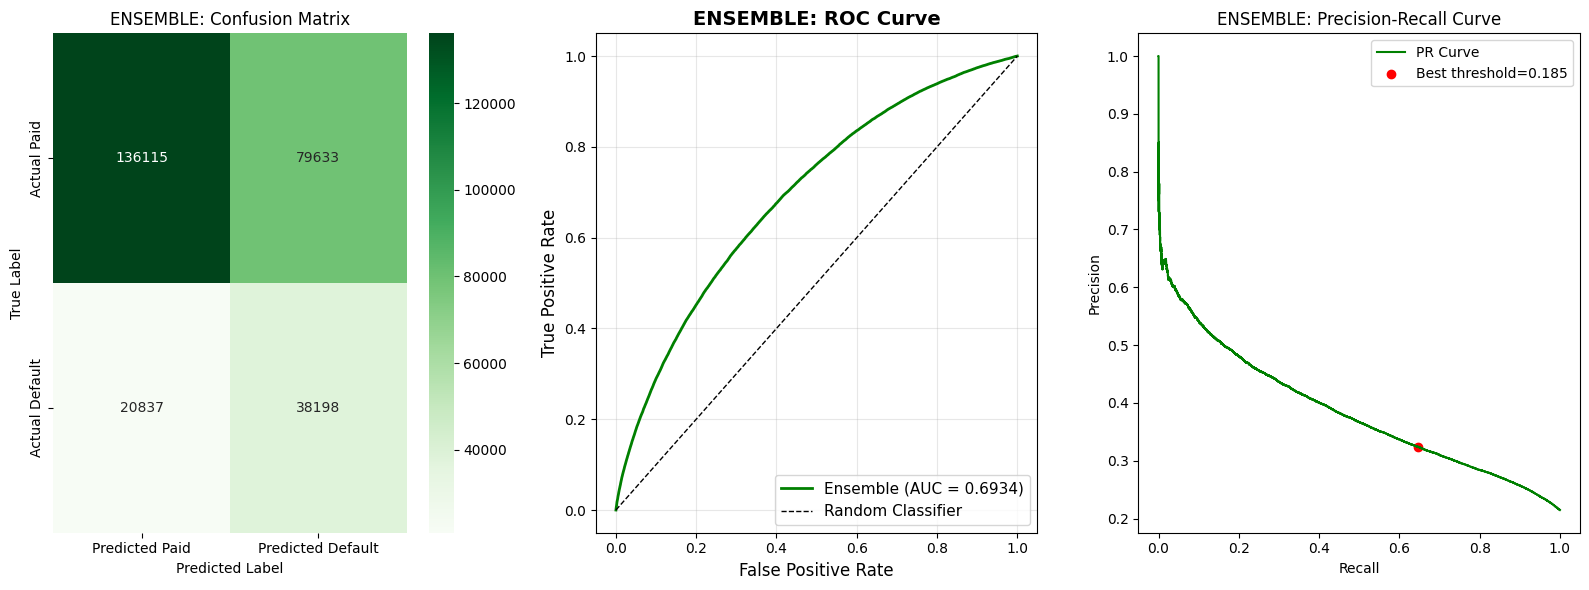


Generating SHAP explanations for Logistic Regression Meta Model...


The figure layout has changed to tight


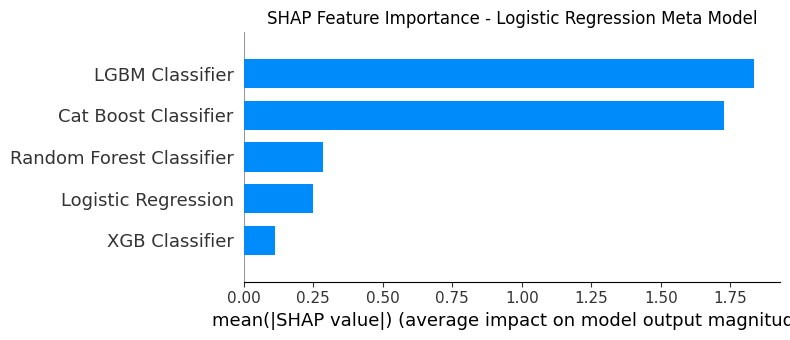

The figure layout has changed to tight


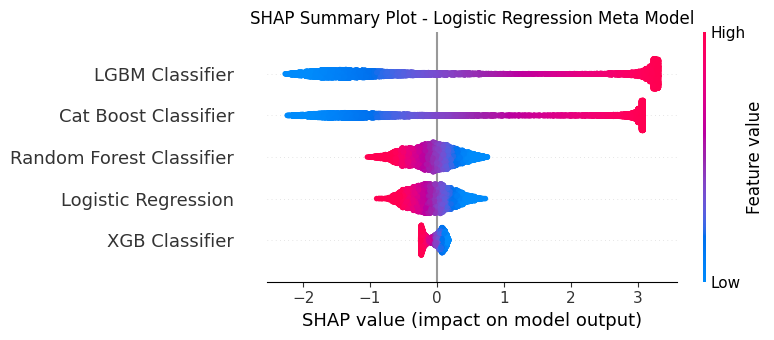

Shap analysis for Random Forest Classifier took 0.02 minutes or 0.94 seconds


In [50]:
print("\n" + "="*60)
print("BUILDING META-MODEL (STACKING ENSEMBLE)")
print("="*60)

# Create meta-features using out-of-fold predictions
meta_train, meta_test = create_meta_features(
    models=models,  # Use the UNTRAINED model dict (not trained_models)
    X_train=X_train_resampled,
    y_train=y_train_resampled,
    X_test=X_test_preprocessed,
    n_folds=5
)

# Train meta-model on out-of-fold predictions
meta_model = LogisticRegression(max_iter=1000, random_state=42)
meta_model.fit(meta_train, y_train_resampled)

# Get meta predictions
y_pred_proba_meta = meta_model.predict_proba(meta_test)[:, 1]

# Compute precision, recall and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_meta)

# Compute F1 for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

# Find best threshold with max f1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]
print(f"Best threshold: {best_threshold:.3f}, Best F1-score {best_f1:.3f}")

# Apply threshold to predictions
y_pred_opt_meta = (y_pred_proba_meta >= best_threshold).astype(int)

# Accuracy
acc = accuracy_score(y_test, y_pred_opt_meta)
print(f"Accuracy: {acc:.2f} \n")

# Classification Report
print("Classification Report.")
print(f"{classification_report(y_test, y_pred_opt_meta)} \n")

# ROC-AUC score
test_roc_auc = roc_auc_score(y_test, y_pred_proba_meta)

# Confusion Matrix
cm_test = confusion_matrix(y_test, y_pred_opt_meta)

# ================== ENSEMBLE PLOTS ==================
fig, ax = plt.subplots(1, 3, figsize=(16,6))

# Confusion Matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=ax[0], 
            xticklabels=['Predicted Paid', 'Predicted Default'],
            yticklabels=['Actual Paid', 'Actual Default'])
ax[0].set_title('ENSEMBLE: Confusion Matrix')
ax[0].set_ylabel('True Label')
ax[0].set_xlabel('Predicted Label')

# ROC Curve
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_meta)
ax[1].plot(fpr_test, tpr_test, label=f'Ensemble (AUC = {test_roc_auc:.4f})', linewidth=2, color='green')
ax[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
ax[1].set_xlabel('False Positive Rate', fontsize=12)
ax[1].set_ylabel('True Positive Rate', fontsize=12)
ax[1].set_title('ENSEMBLE: ROC Curve', fontsize=14, fontweight='bold')
ax[1].legend(loc='lower right', fontsize=11)
ax[1].grid(alpha=0.3)

# Precision-Recall Curve
ax[2].plot(recall, precision, label='PR Curve', color='green')
ax[2].scatter(recall[best_idx], precision[best_idx], color='red', label=f'Best threshold={best_threshold:.3f}')
ax[2].set_xlabel("Recall")
ax[2].set_ylabel("Precision")
ax[2].set_title("ENSEMBLE: Precision-Recall Curve")
ax[2].legend()

plt.tight_layout()
plt.show()

# ================== SHAP ANALYSIS ==================
# Create feature names as the base model names
meta_feature_names = list(trained_models.keys()) 

meta_model_shap_analysis_start = time.time()
shap_values = plot_shap_importance(
    model=meta_model,
    X_train_preprocessed=meta_train,
    model_name="Logistic Regression Meta Model",
    feature_names=meta_feature_names
)
meta_model_shap_analysis_end = time.time() - meta_model_shap_analysis_start
print(f"Shap analysis for {model_name} took {(meta_model_shap_analysis_end/60):.2f} minutes or {meta_model_shap_analysis_end:.2f} seconds")

# Save Model and Preprocessor
---

In [51]:
import pickle

In [52]:
# ==================== SAVE ALL 4 MODELS ====================
print("\n" + "=" * 60)
print("SAVING ENSEMBLE MODEL")
print("=" * 60)

# Save all 4 trained models as a dictionary
ensemble_models = {
    'Logistic Regression': trained_models['Logistic Regression'],
    'XGB Classifier': trained_models['XGB Classifier'],
    'LGBM Classifier': trained_models['LGBM Classifier'],
    'Cat Boost Classifier': trained_models['Cat Boost Classifier']
}

with open('ensemble_model.pkl', 'wb') as f:
    pickle.dump(ensemble_models, f)
print("✓ Ensemble model (all 4 models) saved as 'ensemble_model.pkl'")

# Also save the preprocessor (IMPORTANT!)
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preproces, f)
print("✓ Preprocessor saved as 'preprocessor.pkl'")

# Save best threshold
with open('best_threshold.pkl', 'wb') as f:
    pickle.dump(best_threshold, f)
print(f"✓ Best threshold ({best_threshold:.3f}) saved as 'best_threshold.pkl'")

print("\nModel artifacts saved successfully!")


SAVING ENSEMBLE MODEL
✓ Ensemble model (all 4 models) saved as 'ensemble_model.pkl'
✓ Preprocessor saved as 'preprocessor.pkl'
✓ Best threshold (0.185) saved as 'best_threshold.pkl'

Model artifacts saved successfully!


In [ ]:
# # In your Kaggle notebook, run this to see versions:
# import sklearn
# import catboost

# print(f"scikit-learn: {sklearn.__version__}")
# print(f"pandas: {pandas.__version__}")
# print(f"numpy: {numpy.__version__}")
# print(f"XGBoost: {xgb.__version__}")
# print(f"LightGBM: {lgb.__version__}")
# print(f"CatBoost: {catboost.__version__}")